In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
# from train_bbnet import get_args, load_model
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def zscore(x, eps=1e-6):
    m = x.mean((-2,-1), True)
    s = x.std((-2,-1), True)
    return (x - m) / s.clamp(min=eps)

def get_patches(im, radius=1):
    if radius == 0:
        return im
    shape = im.shape
    if len(shape) == 5:
        im = im.view(shape[0]*shape[1], *shape[2:])
    B,C,H,W = im.shape
    
    im = F.pad(im, (radius, radius, radius, radius))
    k = 2*radius+1
    im = F.unfold(im, (k, k)).view(-1,C*(k**2),H,W)
    if len(shape) == 5:
        im = im.view(shape[0], shape[1], *im.shape[1:])
    return im    
    
def vis_local_affinities(affinities, node=[250,400]):
    aff_node = affinities[:,:,node[0],node[1]]

    A = torch.zeros_like(affinities)
    A[:,:,node[0],node[1]] = aff_node
    K = (aff_node.shape[-1] - 1) // 2
#     aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,K:]], 1)    
    aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,(K+1):]], 1)        
    effects = fprop.compute_local_effects(torch.ones_like(affinities[:,:1]), aff_node)
    return effects

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False, is_test=False, sigmoid=True):
    dataset.is_test = is_test
    dataset.get_backward_frame = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    dataset.get_backward_frame = True
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = (nn.Sigmoid() if sigmoid else nn.Identity())(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  
    

def viz_boundary_preds(b_preds, thresh=0.1, max_speed=0.1, do_plot=True):
    if b_preds.shape[1] == 9:
        c1_preds, b_preds, c2_preds = b_preds.split([4,1,4], dim=-3)
        c_preds = torch.cat([c1_preds, c2_preds], -3).softmax(-3)
        c_preds_rgb = fprop.circular_target_to_spatial_moment(c_preds)
    elif b_preds.shape[1] == 3:
        b_preds, c_preds = b_preds.split([1,2], dim=-3)
        c_preds_rgb = c_preds
    b_preds = b_preds.sigmoid()
    if do_plot:
        vis_utils.imshow(data_utils.FlowToRgb(max_speed=max_speed)(c_preds_rgb) * (b_preds > thresh).float())    
    return (b_preds, c_preds)


def get_boundary_preds(model, dataset, ex, static_input=True, backward=False, iters=12):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]
    if backward:
        ups_mask, b_preds = model(img2, img2 if static_input else img1, test_mode=True, iters=iters)
    else:
        ups_mask, b_preds = model(img1, img1 if static_input else img2, test_mode=True, iters=iters)
    return (b_preds, ups_mask)

def get_boundary_movie(model, dataset, ex, iters=12, thresh=None):
    img1, img2, img0 = [x[None].cuda() for x in dataset[ex][:3]]
    b1 = model(img1, img1, test_mode=True, iters=12)[-1]
    b2 = model(img2, img2, test_mode=True, iters=12)[-1]
    b0 = model(img0, img0, test_mode=True, iters=12)[-1]
    b_movie = []
    for b in [b0, b1, b2]:
        b_preds, c_preds = viz_boundary_preds(b, do_plot=False)
        if thresh is not None:
            b_movie.append((b_preds > thresh).float() * c_preds)
        else:
            b_movie.append(b_preds * c_preds)
    return torch.stack(b_movie, 1)


/home/dbear/tenv/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py:546: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class IteratorBase(collections.Iterator, trackable.Trackable,
/home/dbear/tenv/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:106: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class DatasetV2(collections.Iterable, tracking_base.Trackable,
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resource

In [4]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.losses as losses
import kornia

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(5)],
    split='validation',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


625
True


# Develop faster FuturePredictionLoss

In [7]:
def get_video(dataset, ex=0, stride=1):
    dataset.get_backward_frame = True
    data = dataset[ex]
    video = torch.stack([x.cuda() for x in [data[2], data[0], data[1]]], 0) / 255.
    size = list(video.shape[-2:])
    if stride > 1:
        video = transforms.Resize((size[0] // stride, size[1] // stride))(video)
    return video[None]

FU = targets.FuturePredictionTarget(
    warp_radius=3,
    warp_dilation=1,
    normalize_features=False,
    patch_radius=1,
    error_func='sum',
    distance_func=None,
    target_type='regression',
    beta=100.0
).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*nthr05*fullplay*
motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*pretrained*

# motion_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*pr1*
# motion_paths = !ls ../checkpoints/[0-9]*boundaryMotion*pr1*

motion_paths = sorted(motion_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(motion_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/2500_motion-rnd1-tdw-bs2-large-dtarg-nthr05-cthr05-iters1000-tds2-fullplayall-pretrained1.pth
1 ../checkpoints/2500_motion-rnd1-tdw-bs2-large-dtarg-nthr05-cthr05-iters1000-tds2-fullplayall-pretrained-lr4.pth
2 ../checkpoints/2500_motion-rnd1-tdw-bs2-large-dtarg-nthr05-cthr05-iters1000-tds2-fullplayall-pretrained.pth
3 ../checkpoints/2500_motion-rnd1-tdw-bs2-large-dtarg-nthr05-cthr05-iters2500-tds2-fullplayall-pretrained-lr4.pth
4 ../checkpoints/2500_motion-rnd1-tdw-bs2-large-dtarg-nthr075-cthr05-iters1000-tds2-fullplayall-pretrained.pth
5 ../checkpoints/2500_motion-rnd1-tdw-bs2-large-dtarg-nthr09-cthr05-iters1000-tds2-fullplayall-pretrained-lr4.pth
6 ../checkpoints/2500_motion-rnd1-tdw-bs2-large-dtarg-nthr09-cthr05-iters1000-tds2-fullplayall-pretrained.pth
7 ../checkpoints/2500_motion-rnd1-tdw-bs2-large-dtarg-nthr09-cthr05-iters2500-tds2-fullplayall-pretrained-lr4.pth
8 ../checkpoints/5000_motion-rnd1-tdw-bs2-large-dtarg-nthr05-cthr05-iters1000-tds2-fullplayall-pretrai

In [9]:
import time
m_idx = 50
motion_path = motion_paths[m_idx]
print(motion_path.split('/')[-1])

mclass_net = load_model(
                       motion_path,
                       small=False, 
                       cuda=True, 
                       train=False,
                       static_input=True,
                       orientation_type='regression'
)
mclass_net.module.freeze_bn()
mclass_net.eval()
print(layer_utils.num_parameters(mclass_net))

def get_motion_prior(model, dataset, ex, iters=12, stride=2, backward=False):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]
    if backward:
        _, mprior = model(img2, img1, test_mode=True, iters=iters)
    else:
        _, mprior = model(img1, img2, test_mode=True, iters=iters)        
    if stride > 1:
        size = list(img1.shape[-2:])
        mprior = transforms.Resize((size[0] // stride, size[1] // stride))(mprior)
    return mprior.sigmoid()

def get_motion_features(model, dataset, ex, iters=12, stride=2):
    m1 = get_motion_prior(model, dataset, ex, iters, stride, backward=False)
    m2 = get_motion_prior(model, dataset, ex, iters, stride, backward=True)
    return torch.stack([m1, m2], 1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


32500_motion-rnd1-tdw-bs2-large-dtarg-nthr05-cthr05-iters2500-tds2-fullplayall-pretrained-lr4.pth
<All keys matched successfully> MotionClassifier
5555009


In [30]:
ex = 0
beta = 10.0
tdw_dataset.get_backward_frame = True
tdw_dataset.is_test = True
mfeats = get_motion_features(mclass_net, tdw_dataset, ex=ex, stride=2)
vid = get_video(tdw_dataset, ex=ex, stride=2)

GF = fprop.GrassFire(num_iters=100, normalize=True).cuda().eval()
CT = targets.CentroidTarget(thresh=0.9, compute_offsets=True).cuda().eval()
mask = (mfeats[0] > 0.9).float()
dcentroids, loss_mask = CT(mask.view(1,2,256,256))
dcentroids = dcentroids * loss_mask[:,:,None]

fire = GF(mask.detach())[None]

vid = vid[:,1:]
vid = torch.cat([vid, fire], -3)
# vid = torch.cat([vid, dcentroids], -3)
# vid = torch.cat([vid, fire, dcentroids], -3)
# vid = dcentroids

# vid = fire
# vid = mask[None]


FU.beta = beta
futarget = FU(vid)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
futarget[0].shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 1, 2, 256, 256])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


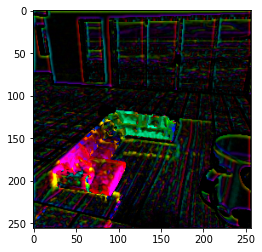

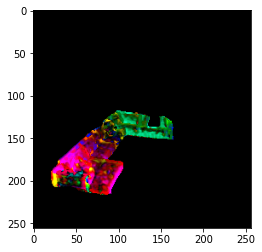

In [31]:
vis_utils.imshow(data_utils.FlowToRgb(max_speed=3.0)(futarget[0][:,0]))
vis_utils.imshow(data_utils.FlowToRgb(max_speed=3.0)(futarget[0][:,0] * (mfeats[:,0] > 0.9).float()))
# vis_utils.imshow(data_utils.FlowToRgb(max_speed=5.0)(futarget[1][:,0] * (mfeats[:,0] > 0.9).float()))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


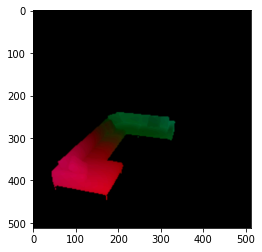

In [15]:
tdw_dataset.get_gt_flow = True
tdw_dataset.get_backward_frame = False
flow = tdw_dataset[ex][2]
flow = torch.stack([-flow[1], flow[0]], 0)
vis_utils.imshow(data_utils.FlowToRgb(max_speed=50.0)(flow[None]))

In [68]:
CT = targets.CentroidTarget(thresh=0.9, compute_offsets=True).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
ctarget, loss_mask = CT(mask.view(1,2,256,256))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
loss_mask.shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 2, 256, 256])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


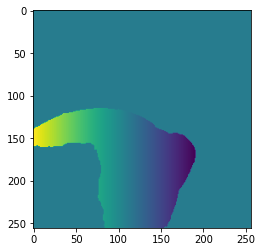

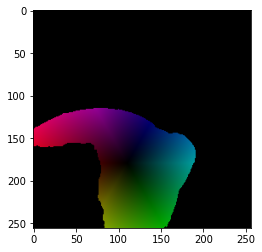

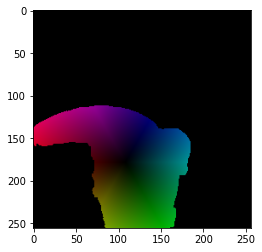

In [76]:
vis_utils.imshow((ctarget[0,0:1,1:2] * loss_mask[:,0:1]))
vis_utils.imshow(data_utils.FlowToRgb(max_speed=1.)(ctarget[0,0:1,:] * loss_mask[:,0:1]))
vis_utils.imshow(data_utils.FlowToRgb(max_speed=1.)(ctarget[0,1:2,:] * loss_mask[:,1:2]))

In [65]:
def rectangle(imsize=[512,512], height=200, width=100, offset=[0,0], rotation=0):
    im = torch.zeros([1,1,*imsize]).float()
    h, w = height // 2, width // 2
    ch, cw = [offset[0] + imsize[0]//2, offset[1] + imsize[1]//2]
    hmin, hmax = max(ch-h, 0), min(ch+h, imsize[0])
    wmin, wmax = max(cw-w, 0), min(cw+w, imsize[1])
    im[:,:,hmin:hmax,wmin:wmax] = 1.0
    if rotation != 0:
        im = transforms.RandomRotation((rotation,rotation))(im)
    return im

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Develop and Test Soft Watershed

In [7]:
tdw_dataset.get_backward_frame = False
tdw_dataset.get_gt_segments = True
tdw_dataset.get_gt_flow = True
tdw_dataset.is_test = True

ex = 11
data = tdw_dataset[ex]
for d in data:
    print(d.shape)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([2, 512, 512])
torch.Size([1, 512, 512])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


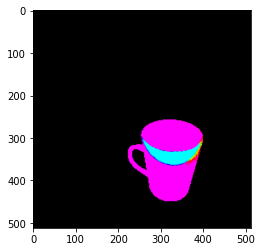

In [10]:
vis_utils.imshow(data_utils.FlowToRgb()(data[-2][None]))

In [630]:
def get_gt_motion_and_boundaries(dataset, ex, max_objects=8, radius=3):
    dataset.get_backward_frame = False
    dataset.get_gt_segments = True
    dataset.get_gt_flow = True    
    
    img1, img2, flow, segments = [x[None].cuda() for x in dataset[ex]]
    motion = (flow.abs().sum(1, True) > 0).float()
    obj_ids = torch.unique(segments)[:max_objects]
    masks = (segments == obj_ids.view(1, -1, 1, 1)).float()
    borders, _ = fprop.get_mask_boundaries(masks)
    masks, borders = masks[:,1:], borders[:,1:]
    size = masks.shape[-2:]
    orients = fprop.estimate_boundary_orientations(
        borders.view(-1, 1, *size),
        masks.view(-1, 1, *size),
        radius=radius,
        to_circle=False
    ).view(1, -1, 2, *size)
    return (img1, flow, motion, masks, borders, orients)

def mask_orientations(masks, boundaries, orientations):
    return (orientations * boundaries[:,:,None] * masks[:,:,None]).sum(1)

def get_adj_gt(masks, radius=3):
    masks = torch.cat([1-masks.amax(1, True), masks], -3)
    segments = masks.argmax(1, True)
    adj_gt = fprop.get_local_neighbors(
        segments, radius=radius, to_image=True, invalid=-1
    )[:,0] == segments
    return adj_gt.float()

def estimate_kp_adj(motion, boundaries, radius=3):
    r = radius
    k = 2*r + 1
    K = k**2
    null_idx = (K - 1) // 2
    B,_,H,W = motion.shape
    adj = F.one_hot(torch.tensor(null_idx), num_classes=K).to(motion.device)
    adj = adj.view(1,1,k,k).repeat(B*H*W, 1, 1, 1)
    mask = fprop.get_local_neighbors(motion, radius=r, invalid=0, to_image=True)[:,0]
    mask = mask.permute(0,2,3,1).reshape(B*H*W,1,k,k)
    adj = adj * mask
    boundaries = fprop.get_local_neighbors(boundaries, radius=r, invalid=0, to_image=True)[:,0]
    b = boundaries.permute(0,2,3,1).reshape(B*H*W,1,k,k)
    
#     u = 1 - adj
    kernel = torch.ones((3,3)).float().view(1,9,1,1).repeat(1,1,k,k).to(b.device)
    
    for it in range(r):
        adj_new = fprop.compute_local_effects(adj, kernel)
#         u = F.relu(u - fprop.compute_local_effects(adj.abs(), kernel))
        adj_new = adj_new * (1 - b) - adj_new.abs() * b
        adj = (adj + adj_new).clamp(min=-1, max=1) * mask        
    adj = F.relu(adj)
    adj = adj.view(B,H*W,K).permute(0,2,1).view(B,K,H,W)
    adj = torch.maximum(adj, boundaries) * motion
    return adj

ex = 0
img, flow, motion, masks, borders, orients = get_gt_motion_and_boundaries(tdw_dataset, ex)

# ex = 21
# _img, _flow, _motion, _masks, _borders, _orients = get_gt_motion_and_boundaries(tdw_dataset, ex)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [637]:
import copy
fp_params = copy.deepcopy(fprop.MotionSegmentTarget.DEFAULT_FP_PARAMS)
kp_params = copy.deepcopy(fprop.MotionSegmentTarget.DEFAULT_KP_PARAMS)
comp_params = copy.deepcopy(fprop.MotionSegmentTarget.DEFAULT_COMP_PARAMS)

## param updates
fp_params.update({
    'radius': 3,
    'num_sample_points': None,
    'resolution': 4
})
kp_params.update({
    'num_iters': 200,
    'project': False
})
comp_params.update({
    'compete_thresh': 0.2,
    'num_competition_rounds': 2
})

MSTarget = fprop.MotionSegmentTarget(
    downsample_factor=4,
    fp_params=fp_params,
    kp_params=kp_params,
    competition_params=comp_params
).cuda()

_cat = lambda x,y: torch.cat([x,y], 0)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [638]:
t1 = time.time()
ms = [0,2]
target = MSTarget(
    motion=masks[:,ms].amax(1, True),
    boundaries=borders[:,ms].amax(1, True),
    orientations=mask_orientations(masks[:,ms], borders[:,ms], orients[:,ms]),
    adj=None
)

# target = MSTarget(
#     motion=_cat(masks, _masks)[:,ms].amax(1, True),
#     boundaries=_cat(borders, _borders)[:,ms].amax(1, True),
#     orientations=_cat(mask_orientations(masks[:,ms], borders[:,ms], orients[:,ms]),
#                       mask_orientations(_masks[:,ms], _borders[:,ms], _orients[:,ms])),
#     adj=None
# )


t2 = time.time()
print(t2 - t1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9065375328063965


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


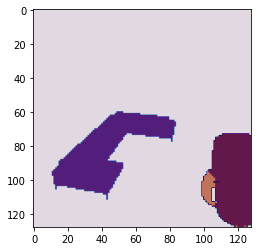

In [639]:
vis_utils.imshow(target[:,None], cmap='twilight', vmin=-1, vmax=target.amax()+1)

In [640]:
import time
FP = fprop.FirePropagation(num_iters=200, normalize=False,
                           dilation_kernel_size=7, 
                           resolution=4,
                           num_sample_points=None,
                           downsample_factor=1,
                           radius=3,
                           compute_kp_args=False
                          ).cuda()

t1 = time.time()
ms = [0,1,2]
fire = FP(masks[:,ms].amax(1, True), borders[:,ms].amax(1, True),  
          mask_orientations(masks[:,ms], borders[:,ms], orients[:,ms]), adj=None)
t2 = time.time()
print(t2 - t1)

0.13338160514831543


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


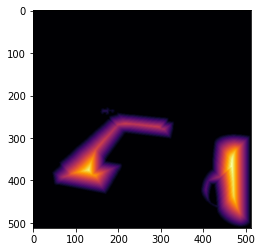

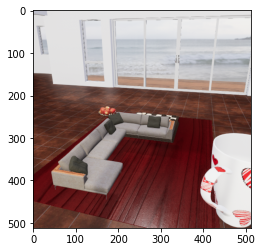

In [641]:
vis_utils.imshow(fire, cmap='inferno', vmin=0, vmax=fire.amax())
# vis_utils.imshow(maxima * 100 + fire)
# dil = kornia.morphology.dilation(fire, kernel=torch.ones((7,7)).cuda())
# vis_utils.imshow((fire == dil).float() * motion)
vis_utils.imshow(img / 255.)

In [391]:
LKP = fprop.LocalKProp(
    num_iters=5,
    channels_last=False
).cuda()

Comp = competition.Competition(
    num_masks=32,
    compete_thresh=0.1,
    num_competition_rounds=2
).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [392]:
import time
t1 = time.time()
s = 4
radius = 3
LKP.num_iters = 200
LKP.inhibit = True
LKP.excite = True
LKP.project = True
motion_mask = masks[:,ms,::s,::s].amax(1, True)
fire_mask = (fire[...,::s,::s] > 0).float() + borders[:,ms,::s,::s].amax(1, True)
h0 = F.avg_pool2d(kp_init, s, stride=s)
t4 = time.time()
# adj_gt = get_adj_gt(masks[:,ms,::s,::s] * motion_mask, radius=radius)
# adj_kp = FP.estimate_kp_adjacency(motion_mask * fire_mask,
#                                  borders[:,ms,::s,::s].amax(1, True), 
#                                   mask=motion_mask,
#                                  radius=radius)
# adj_kp = estimate_kp_adj(motion_mask * fire_mask,
#                          borders[:,ms,::s,::s].amax(1, True), 
#                          radius=radius)
# adj_static = get_adj_gt(1-motion_mask, radius=radius)
# adj_kp = adj_kp * motion_mask + adj_static * (1 - motion_mask)
# adj_gt = adj_gt * motion_mask + (1 - motion_mask) * adj_static
# adj_kp = torch.zeros((1,(2*radius+1)**2,*motion_mask.shape[-2:])).to(adj_kp.device) + adj_kp
activated = F.avg_pool2d(maxima, s, stride=s) > 0
t5 = time.time()
h = LKP(
    h0 * motion_mask,
#     adj_gt.detach(),
    adj_kp.detach(),
    activated.float().detach() * motion_mask)
h = torch.cat([1-motion_mask, h * motion_mask], 1)
out, _, alive, _, _ = Comp(h.detach().permute(0,2,3,1))
t2 = time.time()

print(t2 - t1)
print("adj time", t5 - t4)
print("kp time", t2 - t5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4713625907897949
adj time 0.00018405914306640625
kp time 0.46851181983947754


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


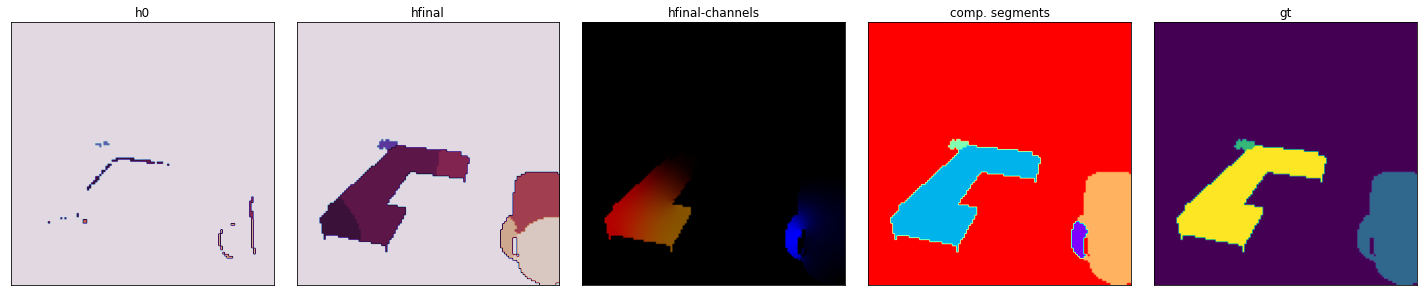

In [393]:
fig, axes = plt.subplots(1,5,figsize=(20,4))
vis_utils.imshow(h0.argmax(1, True) * motion_mask, axes[0], cmap='twilight', vmin=0, vmax=FP.resolution**2 + 1)
vis_utils.imshow(h.argmax(1, True), axes[1], cmap='twilight', vmin=0, vmax=FP.resolution**2 + 1)
vis_utils.imshow(h[:,[9,14,15]], axes[2])

inds = torch.where(alive[0,:,0])[0]
vis_utils.imshow(out[...,inds].argmax(-1)[:,None], axes[3], cmap='rainbow', 
                 vmin=0, vmax=out[...,inds].argmax(-1).amax())
vis_utils.imshow(masks[:,ms,::s,::s].argmax(1, True) * motion_mask - (1 - motion_mask), axes[4])

titles = ['h0', 'hfinal', 'hfinal-channels', 'comp. segments', 'gt']
for i,ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i])
plt.tight_layout()
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


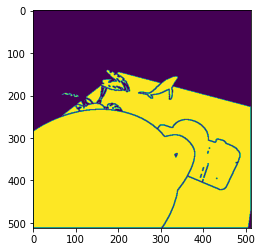

In [145]:
vis_utils.imshow(fire > 0)

In [72]:
adj_kp[...,100,45].view(11,11)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]], device='cuda:0')

## estimate KP adj

In [168]:
torch.arange(49).view(7,7)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[ 0,  1,  2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11, 12, 13],
        [14, 15, 16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25, 26, 27],
        [28, 29, 30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39, 40, 41],
        [42, 43, 44, 45, 46, 47, 48]])

In [208]:
b = torch.zeros((49))
for i in [11,18,32,39]:
    b += F.one_hot(torch.tensor(i), num_classes=49)
b = b.view(1,1,7,7).cuda()
b

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]], device='cuda:0')

In [209]:
a = F.one_hot(torch.tensor(24), num_classes=49).view(1,1,7,7).cuda()
u = 1 - a
kern = torch.tensor([1,1,1,1,1,1,1,1,1]).float().view(1,9,1,1).repeat(1,1,7,7).cuda()
for it in range(5):
    a_new = fprop.compute_local_effects(a, kern) * u
    u = F.relu(u - fprop.compute_local_effects(a.abs(), kern))
    a_new = a_new * (1 - b) - a_new.abs() * b
    a = (a + a_new).clamp(min=-1, max=1)
    print(it)
    print(a)
print(F.relu(a))

0
tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  1.,  1., -1.,  0.,  0.],
          [ 0.,  0.,  1.,  1.,  1.,  0.,  0.],
          [ 0.,  0.,  1.,  1., -1.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]]], device='cuda:0')
1
tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  1.,  1.,  0., -1.,  0.],
          [ 0.,  1.,  1.,  1., -1.,  0.,  0.],
          [ 0.,  1.,  1.,  1.,  1., -1.,  0.],
          [ 0.,  1.,  1.,  1., -1.,  0.,  0.],
          [ 0.,  1.,  1.,  1.,  0., -1.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]]], device='cuda:0')
2
tensor([[[[ 1.,  1.,  1.,  1.,  0., -1., -1.],
          [ 1.,  1.,  1.,  1.,  0., -1., -1.],
          [ 1.,  1.,  1.,  1., -1.,  0., -1.],
          [ 1.,  1.,  1.,  1.,  1., -1., -1.],
          [ 1.,  1.,  1.,  1., -1.,  0., -1.],
          [ 1.,  1.,  1.,  1.,  0., -1., -1.],
          [ 1.

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [302]:
def estimate_kp_adj(motion, boundaries, radius=3):
    r = radius
    k = 2*r + 1
    K = k**2
    null_idx = (K - 1) // 2
    B,_,H,W = motion.shape
    adj = F.one_hot(torch.tensor(null_idx), num_classes=K).to(motion.device)
    adj = adj.view(1,1,k,k).repeat(B*H*W, 1, 1, 1)
    mask = fprop.get_local_neighbors(motion, radius=r, invalid=0, to_image=True)[:,0]
    mask = mask.permute(0,2,3,1).reshape(B*H*W,1,k,k)
    adj = adj * mask
    boundaries = fprop.get_local_neighbors(boundaries, radius=r, invalid=0, to_image=True)[:,0]
    b = boundaries.permute(0,2,3,1).reshape(B*H*W,1,k,k)
    
    u = 1 - adj
    kernel = torch.ones((3,3)).float().view(1,9,1,1).repeat(1,1,k,k).to(b.device)
    
    for it in range(r):
        adj_new = fprop.compute_local_effects(adj, kernel) * u
        u = F.relu(u - fprop.compute_local_effects(adj.abs(), kernel))
        adj_new = adj_new * (1 - b) - adj_new.abs() * b
        adj = (adj + adj_new).clamp(min=-1, max=1) * mask        
    adj = F.relu(adj)
    adj = adj.view(B,H*W,K).permute(0,2,1).view(B,K,H,W)
    adj = torch.maximum(adj, boundaries) * motion
    return adj

adj_kp = estimate_kp_adj(masks.amax(1, True)[...,::4,::4], borders.amax(1, True)[...,::4,::4])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
print(torch.round(1000 * h[0,:,-100+60,-100+5]) / 1000)
print(torch.round(1000 * h[0,:,-100+60,-100+90]) / 1000)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.7650, 0.0000, 0.0000, 0.0000, 0.6450],
       device='cuda:0')


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


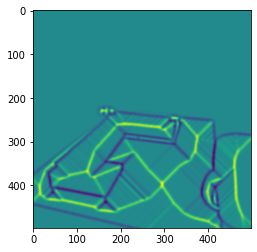

In [219]:
# lap = kornia.filters.laplacian(fire, kernel_size=3) * masks.amax(1, True)
# vis_utils.imshow(lap < -0.25, vmin=0, vmax=0.1)
lap = kornia.filters.get_laplacian_kernel2d(3).view(1,1,3,3)
kernel = transforms.Resize([15, 15])(lap)
x = F.conv2d(fire, -kernel.cuda())
vis_utils.imshow(x)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


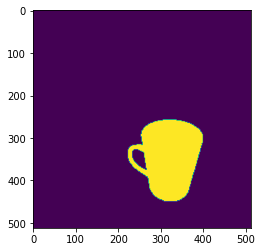

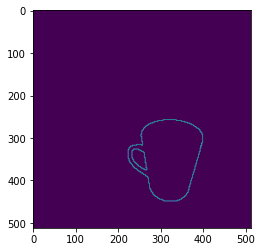

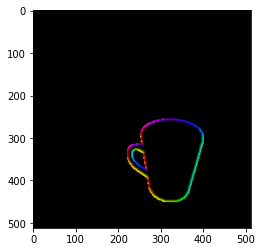

In [198]:
motion = (data[2][None].cuda().abs().sum(1, True) > 0).float()
borders, _ = fprop.get_mask_boundaries(motion)
orients = fprop.estimate_boundary_orientations(
    borders, motion, radius=3
)
vis_utils.imshow(motion)
vis_utils.imshow(borders)
vis_utils.imshow(data_utils.FlowToRgb()(orients))